# High-dimensional Bayesian workflow, with applications to SARS-CoV-2 strains

This tutorial describes a workflow for incrementally building pipelines to analyze high-dimensional data in Pyro. This workflow has evolved over a few years of applying Pyro to models with $10^5$ or more latent variables. We build on [Gelman et al. (2020)](https://arxiv.org/abs/2011.01808)'s concept of *Bayesian workflow*, and focus on aspects particular to high-dimensional models: approximate inference and numerical stability. While the individual components of the pipeline deserve their own tutorials, this tutorial focuses on incrementally combining those components.

The fastest way to find a good model of your data is to quickly discard many bad models, i.e. to iterate.
In statistics we call this iterative workflow [Box's loop](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf).
An efficient workflow allows us to discard bad models as quickly as possible.
Workflow efficiency demands that code changes to upstream components don't break previous coding effort on downstream components.
Pyro's approaches to this challenge include strategies for variational approximations ([pyro.infer.autoguide](https://docs.pyro.ai/en/stable/infer.autoguide.html)) and strategies for transforming model coordinate systems to improve geometry ([pyro.infer.reparam](https://docs.pyro.ai/en/stable/infer.reparam.html)).

#### Summary

- Great models can only be achieved by iterative development.
- Iterate quickly by building a pipeline that is robust to code changes.
- Start with a simple model and [mean-field inference](https://docs.pyro.ai/en/dev/infer.autoguide.html#autonormal).
- Avoid NANs by intelligently [initializing](https://docs.pyro.ai/en/dev/infer.autoguide.html#module-pyro.infer.autoguide.initialization) and [.clamp()](https://pytorch.org/docs/stable/generated/torch.clamp.html)ing.
- [Reparametrize](https://docs.pyro.ai/en/dev/infer.reparam.html) the model to improve geometry.
- Create a custom variational family by combining [AutoGuides](https://docs.pyro.ai/en/dev/infer.autoguide.html) or [EasyGuides](https://docs.pyro.ai/en/dev/contrib.easyguide.html).

#### Table of contents
- [Overview](#Overview)
- [Running example: SARS-CoV-2 strain prediction](#Running-example)
1. [Clean the data](#Clean-the-data)
2. [Create a generative model](#Create-a-generative-model)
3. [Sanity check using mean-field inference](#Sanity-check)
4. [Create an initialization heuristic](#Create-an-initialization-heuristic)
5. [Reparametrize the model](#Reparametrize)
6. [Customize the variational family: autoguides, easyguides, custom guides](#Customize)

## Overview <a name="Overview" />

Consider the problem of sampling from the posterior distribution of a probabilistic model with $10^5$ or more continuous latent variables, but whose data fits entirely in memory.
(For larger datasets, consider [amortized variational inference](http://pyro.ai/examples/svi_part_ii.html).) Inference in such high-dimensional models can be challenging even when posteriors are known to be [unimodal](https://en.wikipedia.org/wiki/Unimodality) or even [log-concave](https://arxiv.org/abs/1404.5886), due to correlations among latent variables.

To perform inference in such high-dimensional models in Pyro, we have evolved a [workflow](https://arxiv.org/abs/2011.01808) to incrementally build data analysis pipelines combining variational inference, reparametrization effects, and ad-hoc initialization strategies. Our workflow is summarized as a sequence of steps, where validation after any step might suggest backtracking to change design decisions at a previous step.

1. Clean the data.
2. Create a generative model.
3. Sanity check using MAP or mean-field inference.
4. Create an initialization heuristic.
5. Reparameterize the model, evaluating results under mean field VI.
6. Customize the variational family (autoguides, easyguides, custom guides).

The crux of efficient workflow is to ensure changes don't break your pipeline. That is, after you build a number of pipeline stages, validate results, and decide to change one component in the pipeline, you'd like to minimize code changes needed in other components. The remainder of this tutorial describes these steps individually, then describes nuances of interactions among stages, then provides an example.

## Running example: SARS-CoV-2 strain prediction <a name="Running-example" />

The running example in this tutorial will be a model [(Obermeyer et al. 2022)](https://www.medrxiv.org/content/10.1101/2021.09.07.21263228v2) of the relative growth rates of different strains of the SARS-CoV-2 virus, based on [open data](https://docs.nextstrain.org/projects/ncov/en/latest/reference/remote_inputs.html) counting different [PANGO lineages](https://cov-lineages.org/) of viral genomic samples collected at different times around the world. There are about 2 million sequences in total.

The model is a high-dimensional regression model with around 1000 coefficients, a multivariate logistic growth function (using a simple [torch.softmax()](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html)) and a [Multinomial](https://pytorch.org/docs/stable/distributions.html#multinomial) likelihood. While the number of coefficients is relatively small, there are about 500,000 local latent variables to estimate, and plate structure in the model should lead to an approximately block diagonal posterior covariance matrix. For an introduction to simple logistic growth models using this same dataset, see the [logistic growth tutorial](logistic-growth.html).

In [1]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os
import torch
import pyro
import pyro.distributions as dist 
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible,
)
from pyro.infer.reparam import AutoReparam, LocScaleReparam
from pyro.nn.module import PyroParam
from pyro.optim import ClippedAdam
from pyro.ops.special import sparse_multinomial_likelihood
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
if torch.cuda.is_available():
    print("Using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("Using CPU")
smoke_test = ('CI' in os.environ)

Using CPU


## Clean the data <a name="Clean-the-data"/>

Our running example will use a pre-cleaned dataset.
We started with Nextstrain's [ncov](https://docs.nextstrain.org/projects/ncov/en/latest/reference/remote_inputs.html) tool for preprocessing, followed by the Broad Institute's [pyro-cov](https://github.com/broadinstitute/pyro-cov/blob/master/scripts/preprocess_nextstrain.py) tool for aggregation, resulting in a dataset of SARS-CoV-2 lineages observed around the world through time.

In [2]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts
dataset = load_nextstrain_counts()

def summarize(x, name=""):
    if isinstance(x, dict):
        for k, v in sorted(x.items()):
            summarize(v, name + "." + k if name else k)
    elif isinstance(x, torch.Tensor):
        print(f"{name}: {type(x).__name__} of shape {tuple(x.shape)} on {x.device}")
    elif isinstance(x, list):
        print(f"{name}: {type(x).__name__} of length {len(x)}")
    else:
        print(f"{name}: {type(x).__name__}")
summarize(dataset)

counts: Tensor of shape (27, 202, 1316) on cpu
features: Tensor of shape (1316, 2634) on cpu
lineages: list of length 1316
locations: list of length 202
mutations: list of length 2634
sparse_counts.index: Tensor of shape (3, 57129) on cpu
sparse_counts.total: Tensor of shape (27, 202) on cpu
sparse_counts.value: Tensor of shape (57129,) on cpu
start_date: datetime
time_step_days: int


## Create a generative model

The first step to using Pyro is creating a generative model, either a python function or a [pyro.nn.Module](https://docs.pyro.ai/en/dev/nn.html#pyro.nn.module.PyroModule). Start simple. Start with a shallow hierarchy and later add latent variables to share statistical strength. Start with a slice of your data then add a [plate]() over multiple slices. Start with simple distributions like [Normal](), [LogNormal](), [Poisson]() and [Multinomial](), then consider overdispersed versions like [StudentT](), [Gamma](), [GammaPoisson]()/[NegativeBinomial](), and [DirichletMultinomial](). Keep your model simple and readable so you can share it and get feedback from domain experts. Use [weakly informative priors](http://www.stat.columbia.edu/~gelman/presentations/weakpriorstalk.pdf).

We'll focus on a multivariate logistic growth model of competing SARS-CoV-2 strains, as described in [Obermeyer et al. (2022)](https://www.medrxiv.org/content/10.1101/2021.09.07.21263228v2). This model uses a numerically stable `logits` parameter in its multinomial likelihood, rather than a `probs` parameter. Similarly upstream variables `init`, `rate`, `rate_loc`, and `coef` are all in log-space. This will mean e.g. that a zero coefficient has multiplicative effect of 1.0, and a positive coefficient has multiplicative effect greater than 1.

Note we scale `coef` by 1/100 because we want to model a very small number, but the automatic parts of Pyro and PyTorch work best for numbers on the order of 1.0 rather than very small numbers. When we later interpret `coef` in a volcano plot we'll need to duplicate this scaling factor.

In [3]:
def model(dataset):
    features = dataset["features"]
    counts = dataset["counts"]
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape
    T, P, S = counts.shape
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5
    time -= time.mean()
    strain_plate = pyro.plate("strain", S, dim=-1)
    place_plate = pyro.plate("place", P, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # Model each region as multivariate logistic growth.
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with pyro.plate("mutation", M, dim=-1):
        coef = pyro.sample("coef", dist.Laplace(0, 0.5))
    with strain_plate:
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T)
    with place_plate, strain_plate:
        rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_scale))
    logits = init + rate * time[:, None, None]
    
    # Observe sequences via a multinomial likelihood.
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

The execution cost of this model is dominated by the multinomial likelihood over a large sparse count matrix.

In [4]:
print("counts has {:d} / {} nonzero elements".format(
    dataset['counts'].count_nonzero(), dataset['counts'].numel()
))

counts has 57129 / 7177464 nonzero elements


To speed up inference (and model iteration!) we'll replace the `pyro.sample(..., Multinomial)` likelihood with an equivalent but much cheaper `pyro.factor` statement using a helper `pyro.ops.sparse_multinomial_likelihood`. 

In [3]:
def model(dataset, predict=None):
    features = dataset["features"]
    counts = dataset["counts"]
    sparse_counts = dataset["sparse_counts"]
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape
    T, P, S = counts.shape
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5
    time -= time.mean()

    # Model each region as multivariate logistic growth.
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with pyro.plate("mutation", M, dim=-1):
        coef = pyro.sample("coef", dist.Laplace(0, 0.5))
    with pyro.plate("strain", S, dim=-1):
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T)
        with pyro.plate("place", P, dim=-2):
            rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
            init = pyro.sample("init", dist.Normal(0, init_scale))
    if predict is not None:  # Exit early during evaluation.
        probs = (init + rate * time[predict]).softmax(-1)
        return probs
    logits = (init + rate * time[:, None, None]).log_softmax(-1)

    # Observe sequences via a cheap sparse multinomial likelihood.
    t, p, s = sparse_counts["index"]
    pyro.factor(
        "obs",
        sparse_multinomial_likelihood(
            sparse_counts["total"], logits[t, p, s], sparse_counts["value"]
        )
    )

## Sanity check using mean field inference

Mean field Normal inference is cheap and robust, and is a good way to sanity check your posterior point estimate, even if the posterior uncertainty may be implausibly narrow. We recommend starting with an [AutoNormal](https://docs.pyro.ai/en/latest/infer.autoguide.html#autonormal) guide, and possibly setting `init_scale` to a small value like `init_scale=0.01` or `init_scale=0.001`.

Note that while MAP estimating via [AutoDelta](https://docs.pyro.ai/en/latest/infer.autoguide.html#autodelta) is even cheaper and more robust than mean-field `AutoNormal`, `AutoDelta` is coordinate-system dependent and is not invariant to reparametrization. Because in our experience most models benefit from some reparameterization, we recommend `AutoNormal` over `AutoDelta` because `AutoNormal` is less sensitive to reparametrization (`AutoDelta` can give incorrect results in some reparametrized models).

In [4]:
def fit_svi(model, guide, lr=0.01, num_steps=1001, log_every=100, plot=True):
    pyro.clear_param_store()
    pyro.set_rng_seed(20211205)
    if smoke_test:
        num_steps = 2

    # Measure model and guide complexity.
    num_latents = sum(
        site["value"].numel()
        for name, site in poutine.trace(guide).get_trace(dataset).iter_stochastic_nodes()
        if not site["infer"].get("is_auxiliary")
    )
    num_params = sum(p.unconstrained().numel() for p in pyro.get_param_store().values())
    print(f"Found {num_latents} latent variables and {num_params} learnable parameters")
    
    # Save gradient norms during inference.
    series = defaultdict(list)
    def hook(g, series):
        series.append(torch.linalg.norm(g.reshape(-1), math.inf).item())
    for name, value in pyro.get_param_store().named_parameters():
        value.register_hook(
            functools.partial(hook, series=series[name + " grad"])
        )

    # Train the guide.
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
    svi = SVI(model, guide, optim, Trace_ELBO())
    num_obs = int(dataset["counts"].count_nonzero())
    for step in range(num_steps):
        loss = svi.step(dataset) / num_obs
        series["loss"].append(loss)
        median = guide.median()  # cheap for autoguides
        for name, value in median.items():
            if value.numel() == 1:
                series[name + " mean"].append(float(value))
        if step % log_every == 0:
            print(f"step {step: >4d} loss = {loss:0.6g}")

    # Plot series to assess convergence.
    if plot:
        plt.figure(figsize=(6, 6))
        for name, Y in series.items():
            if name == "loss":
                plt.plot(Y, "k--", label=name, zorder=0)
            elif name.endswith(" mean"):
                plt.plot(Y, label=name, zorder=-1)
            else:
                plt.plot(Y, label=name, alpha=0.5, lw=1, zorder=-2)
        plt.xlabel("SVI step")
        plt.title("loss, scalar parameters, and gradient norms")
        plt.yscale("log")
        plt.xscale("symlog")
        plt.xlim(0, None)
        plt.legend(loc="best", fontsize=8)
        plt.tight_layout()

In [7]:
%%time
from pyro.infer.autoguide import AutoStructured
guide = AutoStructured(model, init_scale=0.01)
#guide 
fit_svi(model, guide)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 282666608896 bytes.
                        Trace Shapes:            
                         Param Sites:            
       AutoStructured.locs.rate_scale           1
     AutoStructured.scales.rate_scale           1
AutoStructured.scale_trils.rate_scale    1      1
       AutoStructured.locs.init_scale           1
     AutoStructured.scales.init_scale           1
AutoStructured.scale_trils.init_scale    1      1
             AutoStructured.locs.coef        2634
           AutoStructured.scales.coef        2634
      AutoStructured.scale_trils.coef 2634   2634
             AutoStructured.locs.rate      265832
           AutoStructured.scales.rate      265832
                        Sample Sites:            

After each change to the model or inference, you'll validate model outputs, closing [Box's loop](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf). In our running example we'll quantitiatively evaluate using the mean average error (MAE) over the last fully-observed time step.

In [5]:
def mae(true_counts, pred_probs):
    """Computes mean average error between counts and predicted probabilities."""
    pred_counts = pred_probs * true_counts.sum(-1, True)
    error = (true_counts - pred_counts).abs().sum(-1)
    total = true_counts.sum(-1).clamp(min=1)
    return (error / total).mean().item()

def evaluate(
    model, guide, num_particles=100, location="USA / Massachusetts", time=-2
):
    if smoke_test:
        num_particles = 4
    """Evaluate posterior predictive accuracy at the last fully observed time step."""
    with torch.no_grad(), poutine.mask(mask=False):  # makes computations cheaper
        with pyro.plate("particle", num_particles, dim=-3):  # vectorizes
            guide_trace = poutine.trace(guide).get_trace(dataset)
            probs = poutine.replay(model, guide_trace)(dataset, predict=time)
        probs = probs.squeeze().mean(0)  # average over Monte Carlo samples
        true_counts = dataset["counts"][time]
        # Compute global and local KL divergence.
        global_mae = mae(true_counts, probs)
        i = dataset["locations"].index(location)
        local_mae = mae(true_counts[i], probs[i])
    return {"MAE (global)": global_mae, f"MAE ({location})": local_mae}

In [9]:
pprint(evaluate(model, guide))

{'MAE (USA / Massachusetts)': 0.26023179292678833,
 'MAE (global)': 0.22586050629615784}


We'll also qualitatively evaluate using a volcano plot showing the effect size and statistical significance of each mutation's coefficient, and labeling the mutation with the most significant positive effect. We expect:
- most mutations have very little effect (they are near zero in log space, so their multiplicative effect is near 1x)
- more mutations have positive effect than netagive effect
- effect sizes are on the order of 1.1 or 0.9.

In [6]:
def plot_volcano(guide, num_particles=100):
    if smoke_test:
        num_particles = 4
    with torch.no_grad(), poutine.mask(mask=False):  # makes computations cheaper
        with pyro.plate("particle", num_particles, dim=-3):  # vectorizes
            trace = poutine.trace(guide).get_trace(dataset)
            trace = poutine.trace(poutine.replay(model, trace)).get_trace(dataset, -1)
            coef = trace.nodes["coef"]["value"].cpu()
    coef = coef.squeeze() * 0.01  # Scale factor as in the model.
    mean = coef.mean(0)
    std = coef.std(0)
    z_score = mean.abs() / std
    effect_size = mean.exp().numpy()
    plt.figure(figsize=(6, 3))
    plt.scatter(effect_size, z_score.numpy(), lw=0, s=5, alpha=0.5, color="darkred")
    plt.yscale("symlog")
    plt.ylim(0, None)
    plt.xlabel("$R_m/R_{wt}$")
    plt.ylabel("z-score")
    i = int((mean / std).max(0).indices)
    plt.text(effect_size[i], z_score[i] * 1.1, dataset["mutations"][i], ha="center", fontsize=8)
    plt.title(f"Volcano plot of {len(mean)} mutations")

#plot_volcano(guide)

## Create an initialization heuristic

In high-dimensional models, convergence can be slow and NANs arise easily, even when sampling from [weakly informative priors](http://www.stat.columbia.edu/~gelman/presentations/weakpriorstalk.pdf). We recommend heuristically initializing a point estimate for each latent variable, aiming to initialize at something that is the right order of magnitude. Often you can initialize to a simple statistic of the data, e.g. a mean or standard deviation.

Pyro's autoguides provide a number of [initialization strategies]() for initializing the location parameter of many variational families, specified as `init_loc_fn`. You can create a custom initializer by accepting a pyro sample site dict and generating a sample from `site["name"]` and `site["fn"]` using e.g. `site["fn"].shape()`, `site["fn"].support`, `site["fn"].mean`, or sampling via `site["fn"].sample()`.

In [7]:
def init_loc_fn(site):
    shape = site["fn"].shape()
    if site["name"] == "coef":
        return torch.randn(shape).sub_(0.5).mul(0.01)
    if site["name"] == "init":
        # Heuristically initialize based on data.
        return dataset["counts"].mean(0).add(0.01).log()
    return init_to_feasible(site)  # fallback

As you evolve a model, you'll add and remove and rename latent variables. We find it useful to require inits for all latent variables, add a message to remind yourself to udpate the `init_loc_fn` whenever the model changes.

In [8]:
def init_loc_fn(site):
    shape = site["fn"].shape()
    if site["name"].endswith("_scale"):
        return torch.ones(shape)
    if site["name"] == "coef":
        return torch.randn(shape).sub_(0.5).mul(0.01)
    if site["name"] == "rate":
        return torch.zeros(shape)
    if site["name"] == "init":
        return dataset["counts"].mean(0).add(0.01).log()
    raise NotImplementedError(f"TODO initialize latent variable {site['name']}")

In [11]:
%%time
guide = AutoNormal(model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(model, guide, lr=0.02)
pprint(evaluate(model, guide))
plot_volcano(guide)

Found 538452 latent variables and 1068600 learnable parameters
step    0 loss = 127.475


KeyboardInterrupt: 

## Reparametrize the model

Reparametrizing a model preserves its distribution while changing its geometry. Reparametrizing is simply a change of coordinates. When reparametrizing we aim to warp a model's geometry to remove correlations and to lift inconvenient topological manifolds into simpler higher dimensional flat Euclidean space.

Whereas many probabilistic programming languages require users to rewrite models to change coordinates, Pyro implements a library of about 15 different reparametrization effects including decentering (Gorinova et al. 2020), Haar wavelet transforms, and neural transport (Hoffman et al. 2019), as well as strategies to automatically apply effects and machinery to create custom reparametrization effects. Using these reparametrizers you can separate modeling from inference: first specify a model in a form that is natural to domain experts, then in inference code, reparametrize the model to have geometry that is more amenable to variational inference.

In our SARS-CoV-2 model, the geometry might improve if we change
```diff
- rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
+ rate = pyro.sample("rate", dist.Normal(0, 1)) * rate_scale + rate_loc
```
but that would make the model less interpretable. Instead we can reparametrize the model

In [14]:
reparam_model = poutine.reparam(model, config={"rate": LocScaleReparam()})

or even automatically apply a set of recommended reparameterizers

In [15]:
reparam_model = AutoReparam()(model)

Let's try reparametrizing both sites "rate" and "init". Note we'll create a fresh `reparam_model` each time we train a guide, since the parameters are stored in that `reparam_model` instance. Take care to use the `reparam_model` in downstream prediction tasks like running `evaluate(reparam_model, guide)`.

Found 538452 latent variables and 1068602 learnable parameters
step    0 loss = 127.368
step  100 loss = 20.2831
step  200 loss = 11.0703
step  300 loss = 9.64594
step  400 loss = 9.52988
step  500 loss = 9.09012
step  600 loss = 9.25454
step  700 loss = 8.60661
step  800 loss = 8.9332
step  900 loss = 8.64206
step 1000 loss = 8.56663
{'MAE (USA / Massachusetts)': 0.1336274892091751,
 'MAE (global)': 0.1719919890165329}
CPU times: user 4min 21s, sys: 3min 9s, total: 7min 31s
Wall time: 2min 17s


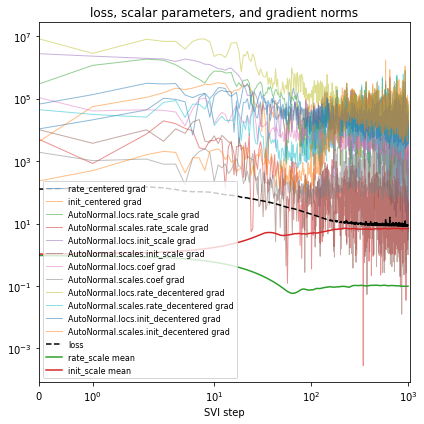

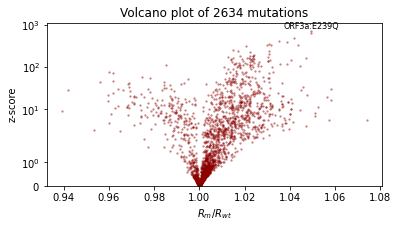

In [16]:
%%time
reparam_model = poutine.reparam(
    model, {"rate": LocScaleReparam(), "init": LocScaleReparam()}
)
guide = AutoNormal(reparam_model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(reparam_model, guide, lr=0.05)
pprint(evaluate(reparam_model, guide))
plot_volcano(guide)

## Customize the variational family

When creating a new model, we recommend starting with mean field variational inference using an [AutoNormal]() guide. This mean field guide is good at finding the neighborhood of your model's mode, but naively it ignores correlations between latent variables. A first step in capturing correlations is to reparametrize the model as above: using a `LocScaleReparam` or `HaarReparam` (where appropriate) already allows the guide to capture some correlations among latent variables.

The next step towards modeling uncertainty is to customize the variational family by trying other autoguides, building on [EasyGuide](), or creating a custom guide using Pyro primitives. We recommend increasing guide complexity gradually via these steps:
1. Start with an [AutoNormal]() guide.
2. Try [AutoLowRankMultivariateNormal](), which can model the principle components of correlated uncertainty. (For models with only ~100 latent variables you might also try [AutoMultivariateNormal]() or [AutoGaussian]()).
3. Try combining multiple guides using [AutoGuideList](). For example if [AutoLowRankMultivariateNormal]() is too expensive for all the latent variables, you can use [AutoGuideList]() to combine an [AutoLowRankMultivariateNormal]() guide over a few top-level global latent variables, together with a cheaper [AutoNormal]() guide over more numerous local latent variables.
4. Try using [AutoGuideList]() to combine a autoguide together with a custom guide function built using `pyro.sample`, `pyro.param`, and `pyro.plate`. Given a `partial_guide()` function that covers just a few latent variables, you can `AutoGuideList.append(partial_guide)` just as you append autoguides.
5. Consider customizing one of Pyro's autoguides that leverage model structure, e.g. [AutoStructured](https://docs.pyro.ai/en/latest/infer.autoguide.html#autostructured), [AutoNormalMessenger](https://docs.pyro.ai/en/latest/infer.autoguide.html#autonormalmessenger), [AutoHierarchicalNormalMessenger](https://docs.pyro.ai/en/latest/infer.autoguide.html#autohierarchicalnormalmessenger) [AutoRegressiveMessenger](https://docs.pyro.ai/en/latest/infer.autoguide.html#autoregressivemessenger).
6. For models with local correlations, consider building on [EasyGuide](https://docs.pyro.ai/en/latest/contrib.easyguide.html), a framework for building guides over groups of variables.

While a fully-custom guides built from `pyro.sample` primitives offer the most flexible variational family, they are also the most brittle guides because each code change to the model or reparametrizer requires changes in the guide. The author recommends avoiding completely low-level guides and instead using `AutoGuide` or `EasyGuide` for at least some parts of the model, thereby speeding up model iteration.

Let's first try a simple `AutoLowRankMultivariateNormal` guide.

In [13]:
%%time
from pyro.infer.autoguide import AutoStructured
reparam_model = poutine.reparam(
    model, {"rate": LocScaleReparam(), "init": LocScaleReparam()}
)
guide = AutoStructured(
    reparam_model, init_loc_fn=init_loc_fn, init_scale=0.01
)
fit_svi(reparam_model, guide, num_steps=10, log_every=1, plot=False)
# don't even bother to evaluate, since this is too slow.

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 282666608896 bytes.
                        Trace Shapes:            
                         Param Sites:            
       AutoStructured.locs.rate_scale           1
     AutoStructured.scales.rate_scale           1
AutoStructured.scale_trils.rate_scale    1      1
       AutoStructured.locs.init_scale           1
     AutoStructured.scales.init_scale           1
AutoStructured.scale_trils.init_scale    1      1
             AutoStructured.locs.coef        2634
           AutoStructured.scales.coef        2634
      AutoStructured.scale_trils.coef 2634   2634
  AutoStructured.locs.rate_decentered      265832
AutoStructured.scales.rate_decentered      265832
                        Sample Sites:            

Yikes! This is quite slow and sometimes runs out of memory on GPU.

Let's make this cheaper by using `AutoGuideList` to combine an `AutoLowRankMultivariateNormal` guide over the most important variables `rate_scale`, `init_scale`, and `coef`, together with a simple cheap `AutoNormal` guide on the rest of the model (the expensive `rate` and `init` variables). The typical pattern is to create two views of the model with [poutine.block](https://docs.pyro.ai/en/stable/poutine.html#pyro.poutine.handlers.block), one exposing the target variables and the other hiding them.

In [11]:
%%time
reparam_model = poutine.reparam(
    model, {"rate": LocScaleReparam(), "init": LocScaleReparam()}
)
guide = AutoGuideList(reparam_model)
mvn_vars = ["coef", "rate_scale", "coef_scale"]
guide.add(
    AutoLowRankMultivariateNormal(
        poutine.block(reparam_model, expose=mvn_vars),
        init_loc_fn=init_loc_fn,
        init_scale=0.01,
    )
)
guide.add(
    AutoNormal(
        poutine.block(reparam_model, hide=mvn_vars),
        init_loc_fn=init_loc_fn,
        init_scale=0.01,
    )
)
fit_svi(reparam_model, guide, lr=0.1)
pprint(evaluate(reparam_model, guide))
plot_volcano(guide)

NameError: name 'init_loc_fn' is not defined

Next let's create a custom guide for part of the model, just the `rate` and `init` parts. Since we'll want to use this with reparametrizers, we'll make the guide use the auxiliary latent variables created by `poutine.reparam`, rather than the original `rate` and `init` variables. Let's see what these variables are named:

In [10]:
for name, site in poutine.trace(reparam_model).get_trace(
    dataset
).iter_stochastic_nodes():
    print(name)

NameError: name 'reparam_model' is not defined

It looks like these new auxiliary variables are called `rate_decentered` and `init_decentered`.

In [9]:
def local_guide(dataset):
    # Create learnable parameters.
    T, P, S = dataset["counts"].shape
    r_loc = pyro.param("rate_decentered_loc", lambda: torch.zeros(P, S))
    i_loc = pyro.param("init_decentered_loc", lambda: torch.zeros(P, S))
    skew = pyro.param("skew", lambda: torch.zeros(P, S))  # allows correlation
    r_scale = pyro.param("rate_decentered_scale", lambda: torch.ones(P, S),
                          constraint=constraints.softplus_positive)
    i_scale = pyro.param("init_decentered_scale", lambda: torch.ones(P, S),
                          constraint=constraints.softplus_positive)

    # Sample local variables inside plates.
    # Note plates are already created by the main guide, so we'll
    # use the existing plates rather than calling pyro.plate(...).
    with guide.plates["place"], guide.plates["strain"]:
        samples = {}
        samples["rate_decentered"] = pyro.sample(
            "rate_decentered", dist.Normal(r_loc, r_scale)
        )
        i_loc = i_loc + skew * samples["rate_decentered"]
        samples["init_decentered"] = pyro.sample(
            "init_decentered", dist.Normal(i_loc, i_scale)
        )
    return samples

In [10]:
%%time
from pyro.infer.autoguide import AutoStructured
reparam_model = poutine.reparam(
    model, {"rate": LocScaleReparam(), "init": LocScaleReparam()}
)
guide = AutoGuideList(reparam_model)
local_vars = ["rate_decentered", "init_decentered"]
guide.add(
    AutoStructured(
        poutine.block(reparam_model, hide=local_vars),
        init_loc_fn=init_loc_fn,
        init_scale=0.01,
    )
)
guide.add(local_guide)
fit_svi(reparam_model, guide, lr=0.1)
pprint(evaluate(reparam_model, guide))
plot_volcano(guide)

Graph with 4 nodes and 3 edges
Found 538452 latent variables and 8277661 learnable parameters
step    0 loss = 5435.22
step  100 loss = 33.2084
step  200 loss = 20.4117
step  300 loss = 15.5226
step  400 loss = 13.483


KeyboardInterrupt: 

## Conclusion

We've seen how to use initialization, reparameterization, autoguides, and custom guides in a Bayesian workflow. For more examples of these pieces of machinery, we recommend exploring the Pyro codebase, e.g. [search for "poutine.reparam"](https://github.com/pyro-ppl/pyro/search?q=poutine.reparam&type=code) or ["init_loc_fn"](https://github.com/pyro-ppl/pyro/search?q=init_loc_fn&type=code) in the Pyro codebase.